In [1]:
# import modules
from math import inf
from math import log
import numpy as np
from scipy.stats import nbinom
from collections import defaultdict
from scipy.optimize import minimize
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# log func

In [2]:
'''
    convert to log form
    number: scalar
    output: scalar
'''
def log_func(number):
    if number > 0:
        return log(number)
    else:
        return -inf

# log-sum-exp

In [105]:
'''
    HMM Notes p17
    log sum(exp(x1)+exp(x2)+...)
    x: list
    result: scalar
'''
def logSumExp(x):
    m = max(x)
    if m == -inf: # infinity
        return -inf
    else:
        minus_m = np.array(x) - m
        result = m + log(sum(np.exp(minus_m)))
        return result   

In [16]:
# examples
# x = list(range(-100,-50))
# log(sum(np.exp(x)))
# logSumExp(x)

# log likelihood f(x)

In [104]:
'''
    Notes p2
    x: scalar. Realization from NB distribution
    alpha, beta: scalar. Parameters from Gamma distribution
    E: scalar. Normalization factor for n-th sequence
    result: scalar. Log likelihood f(x)
'''
def lnNB(x, alpha, beta, E):
    r = alpha
    p = beta / (E+beta)
    result = nbinom.logpmf(x, r, p) # x follows NB(alpha, beta/(E+beta))
    return result

In [103]:
# examples
#x = 50
#alpha = 1
#beta = 0.1
#E = 10
#lnNB(x, alpha, beta, E)

-5.112637059499664

# Forward

In [16]:
'''
    Calculate forward algorithm given the next codon won't start 
    i: integer. Current i-th element inside this RNA sequence
    prob_current: a list of 21 probabilites. Indicates current forward algorithm
    prob_next: a list of 21 probabilites. Indicates next forward algorithm, updating this value
    observed_data: a list. Indicates the height of a sequence and this list contains scalars
    alpha_list: a list of alpha values for 21 states (NB parameter)
    beta_list: a list of beta values for 21 states (NB parameter)
    E: scalar. Normalization factor for this specific sequences
    output: prob_next
'''
def start_codon_false(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E):
    
    # state 1 to state 1
    temp = prob_current[0] +  log(1) + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E) 
    prob_next[0] = temp
        
    # state 10 and state 11 to state 11     
    log_10_11 = prob_current[9] + log(1) 
    log_11_11 = prob_current[10] + log(1) 
    temp = [log_10_11, log_11_11]
    prob_next[10] = logSumExp(temp) + lnNB(observed_data[i+1], alpha_list[10], beta_list[10], E)
    
    return prob_next

In [17]:
'''
    Calculate forward algorithm given the next codon is one of the start codons 
    i: integer. Current i-th element inside this RNA sequence
    prob_current: a list of 21 probabilites. Indicates current forward algorithm
    prob_next: a list of 21 probabilites. Indicates next forward algorithm, updating this value
    trans: a dictionary that key is the start codon (string), value is a list of scalars (three transition probability)
    next_codon: string. Indicates the specific start codon
    observed_data: a list. Indicates the height of a sequence and this list contains scalars
    alpha_list: a list of alpha values for 21 states (NB parameter)
    beta_list: a list of beta values for 21 states (NB parameter)
    E: scalar. Normalization factor for this specific sequences
    output: prob_next
'''
def start_codon_true(i, prob_current, prob_next, trans, next_codon, observed_data, alpha_list, beta_list, E):
    
    # state 1 to state 1
    log_1_1 = log_func(1 - trans[next_codon][0] - trans[next_codon][1])
    temp = prob_current[0] + log_1_1  + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E) 
    prob_next[0] = temp     
            
    # state 1 to state 2
    log_1_2 = log_func(trans[next_codon][0])
    temp = prob_current[0] + log_1_2 + lnNB(observed_data[i+1], alpha_list[1], beta_list[1], E)
    prob_next[1] = temp
            

    # state 1 and state 11 to state 12 
    log_1_12 = prob_current[0] + log_func(trans[next_codon][1])
    log_11_12 = prob_current[10] + log_func(trans[next_codon][2])
    temp = [log_1_12, log_11_12]   
    prob_next[11] = logSumExp(temp) + lnNB(observed_data[i+1], alpha_list[11], beta_list[11], E)
    
    # state 10 and state 11 to state 11     
    log_10_11 = prob_current[9] + log(1) 
    log_11_11 = prob_current[10] + log_func(1 - trans[next_codon][2])
    temp = [log_10_11, log_11_11]
    prob_next[10] = logSumExp(temp) + lnNB(observed_data[i+1], alpha_list[10], beta_list[10], E)
    
    return prob_next

In [18]:
'''
    Calculate forward algorithm given the next codon won't stop
    i: integer. Current i-th element inside this RNA sequence
    prob_current: a list of 21 probabilites. Indicates current forward algorithm
    prob_next: a list of 21 probabilites. Indicates next forward algorithm, updating this value
    observed_data: a list. Indicates the height of a sequence and this list contains scalars
    alpha_list: a list of alpha values for 21 states (NB parameter)
    beta_list: a list of beta values for 21 states (NB parameter)
    E: scalar. Normalization factor for this specific sequences
    output: prob_next
'''
def stop_codon_false(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E):
    
    # state 4 and state 7 to state 5
    log_4_5 = prob_current[3] + log(1) 
    log_7_5 = prob_current[6] + log(1)
    temp = [log_4_5, log_7_5]
    prob_next[4] = logSumExp(temp) + lnNB(observed_data[i+1], alpha_list[4], beta_list[4], E)
        
    # state 14 and state 17 to state 15
    log_14_15 = prob_current[13] + log(1) 
    log_17_15 = prob_current[16] + log(1) 
    temp = [log_14_15, log_17_15]
    prob_next[14] = logSumExp(temp) + lnNB(observed_data[i+1], alpha_list[14], beta_list[14], E)
    
    return prob_next

In [19]:
'''
    Calculate forward algorithm given the next codon is one of the stop codons 
    i: integer. Current i-th element inside this RNA sequence
    prob_current: a list of 21 probabilites. Indicates current forward algorithm
    prob_next: a list of 21 probabilites. Indicates next forward algorithm, updating this value
    observed_data: a list. Indicates the height of a sequence and this list contains scalars
    alpha_list: a list of alpha values for 21 states (NB parameter)
    beta_list: a list of beta values for 21 states (NB parameter)
    E: scalar. Normalization factor for this specific sequences
    output: prob_next
'''
def stop_codon_true(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E):
    
    # state 4 to state 5
    prob_next[4] = prob_current[3] + log(1) + lnNB(observed_data[i+1], alpha_list[4], beta_list[4], E)
        
     # state 7 to state 8
    prob_next[7] = prob_current[6] + log(1) + lnNB(observed_data[i+1], alpha_list[7], beta_list[7], E)
    
    # state 14 to 15
    prob_next[14] = prob_current[13] + log(1) + lnNB(observed_data[i+1], alpha_list[14], beta_list[14], E)
   
    # state 17 to state 18
    prob_next[17] = prob_current[16] + log(1) + lnNB(observed_data[i+1], alpha_list[17], beta_list[17], E)
    
    return prob_next

In [20]:
'''
    Compute and store the forward algorithm for a given sequence
    RNA_data: a list of lists. Each inner list indicates a single RNA sequence and this list contains letters 'A', 'C', 'U', 'G'
    observed_data: a list of lists. Each inner list indicates the height of a sequence and this list contains scalars
    alpha_list: a list of alpha values for 21 states (NB parameter)
    beta_list: a list of beta values for 21 states (NB parameter)
    E: a list of scalars. Normalization factor for all sequences
    trans: a dictionary that key is the start codon (string), value is a list of scalars (three transition probability)
    stop_codon_list: a list of stop codons (string)
    num_sequence: scalar indicates n-th sequence
    output: matrix stores the forward algorithm for single RNA sequence
'''
def forward_algorithm(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, num_sequence):

    # Find E, observed_data, RNA_data according to the order of sequences
    E = E[num_sequence - 1]
    observed_data = observed_data[num_sequence - 1]
    RNA_data = RNA_data[num_sequence - 1]
    
    sequence_length = len(RNA_data) # length of data
    output = np.zeros((sequence_length, 21)) # initialize output matrix
    prob_current = np.ones(21) * (-inf) # initialize probability, 21 different states
    prob_current[0] = lnNB(observed_data[0], alpha_list[0], beta_list[0], E)
    output[0] = prob_current
    
    for i in range(sequence_length - 1):
        start_codon = False
        stop_codon = False
        next_codon = ""
        prob_next = np.ones(21) * (-inf)
        
        # Check start and stop codon
        if i + 3 < sequence_length:
            next_codon = RNA_data[i+1] + RNA_data[i+2] + RNA_data[i+3]  
        if next_codon in trans.keys():
            start_codon = True
        if next_codon in stop_codon_list:
            stop_codon = True
        
        # start codon is false
        if start_codon == False:               
            prob_next = start_codon_false(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E)
        
        # start codon is ture
        elif start_codon == True:   
            prob_next = start_codon_true(i, prob_current, prob_next, trans, next_codon, observed_data, 
                                           alpha_list, beta_list, E)
        
        # stop codon is ture
        if stop_codon == True: 
            prob_next = stop_codon_true(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E)
 
        # stop codon is false
        elif stop_codon == False:
            prob_next = stop_codon_false(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E)
       
        # transter to next state with probability 1
        sure_to_transit = [1, 2, 4, 5, 7, 8, 11, 12, 14, 15, 17, 18]
        for k in sure_to_transit:
            temp = prob_current[k] + log(1) + lnNB(observed_data[i+1], alpha_list[k+1], beta_list[k+1], E)
            prob_next[k+1] = temp

        # state 20 and state 21 to state 21     
        log_20_21 = prob_current[19] + log(1) 
        log_21_21 = prob_current[20] + log(1) 
        temp = [log_20_21, log_21_21]
        prob_next[20] = logSumExp(temp) + lnNB(observed_data[i+1], alpha_list[20], beta_list[20], E)
    
        prob_current = prob_next
        output[i+1] = prob_current
  
    return output

In [21]:
'''
    Compute forward matrix by combining result from each single sequence
    RNA_data: a list of lists. Each inner list indicates a single RNA sequence and this list contains letters 'A', 'C', 'U', 'G'
    observed_data: a list of lists. Each inner list indicates the height of a sequence and this list contains scalars
    alpha_list: a list of alpha values for 21 states (NB parameter)
    beta_list: a list of beta values for 21 states (NB parameter)
    E: a list of scalars. Normalization factor for all sequences
    trans: a dictionary that key is the start codon (string), value is a list of scalars (three transition probability)
    stop_codon_list: a list of stop codons (string)
    output: matrix stores the forward algorithm for multiple RNA sequences
'''
def forward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list):
    output = []
    for n in range(1, len(observed_data)+1):
        output.append(forward_algorithm(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, n))
    return output

In [106]:
# forward = forward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)

# Backward

In [23]:
'''
    Calculate backward algorithm given the next codon won't start 
    i: integer. Current i-th element inside this RNA sequence
    prob_current_back: a list of 21 probabilites. Indicates current backward algorithm
    prob_previous_back: a list of 21 probabilites. Indicates previous backward algorithm, updating this value
    observed_data: a list. Indicates the height of a sequence and this list contains scalars
    alpha_list: a list of alpha values for 21 states (NB parameter)
    beta_list: a list of beta values for 21 states (NB parameter)
    E: scalar. Normalization factor for this specific sequences
    output: prob_previous_back
'''
def start_codon_false_back(i, prob_current_back, prob_previous_back, observed_data, alpha_list, beta_list, E):
    
    # state 1 to state 1
    temp = prob_current_back[0] + log(1) + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E) 
    prob_previous_back[0] = temp
 

    # state 11 to state 11     
    temp = prob_current_back[10] + log(1) + lnNB(observed_data[i+1], alpha_list[10], beta_list[10], E)
    prob_previous_back[10] = temp
    
    return prob_previous_back

In [24]:
'''
    Calculate backward algorithm given the next codon is one of the start codons 
    i: integer. Current i-th element inside this RNA sequence
    prob_current_back: a list of 21 probabilites. Indicates current backward algorithm
    prob_previous_back: a list of 21 probabilites. Indicates previous backward algorithm, updating this value
    trans: a dictionary that key is the start codon (string), value is a list of scalars (three transition probability)
    next_codon: string. Indicates the specific start codon
    observed_data: a list. Indicates the height of a sequence and this list contains scalars
    alpha_list: a list of alpha values for 21 states (NB parameter)
    beta_list: a list of beta values for 21 states (NB parameter)
    E: scalar. Normalization factor for this specific sequences
    output: prob_previous_back
'''
def start_codon_true_back(i, prob_current_back, prob_previous_back, trans, next_codon, observed_data, alpha_list, beta_list, E):
    
    # state 1 to state 1
    temp = log_func(1 - trans[next_codon][0] - trans[next_codon][1])
    log_1_1 = prob_current_back[0] + temp + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E)
    
    # state 1 to state 2
    temp = log_func(trans[next_codon][0])
    log_1_2 = prob_current_back[1] + temp + lnNB(observed_data[i+1], alpha_list[1], beta_list[1], E) 
    
    # state 1 to state 12
    temp = log_func(trans[next_codon][1]) 
    log_1_12 = prob_current_back[11] + temp + lnNB(observed_data[i+1], alpha_list[11], beta_list[11], E) 
    
    temp = [log_1_1, log_1_2, log_1_12]
    prob_previous_back[0] = logSumExp(temp)
            
            
    # state 11 to state 11, 12
    temp = log_func(1 - trans[next_codon][2])
    log_11_11 = prob_current_back[10] + temp + lnNB(observed_data[i+1], alpha_list[10], beta_list[10], E) 
    
    temp = log_func(trans[next_codon][2])
    log_11_12 = prob_current_back[11] + temp + lnNB(observed_data[i+1], alpha_list[11], beta_list[11], E) 
    
    temp = [log_11_11, log_11_12]
    prob_previous_back[10] = logSumExp(temp)
    
    return prob_previous_back

In [25]:
'''
    Calculate backward algorithm given the next codon won't stop
    i: integer. Current i-th element inside this RNA sequence
    prob_current_back: a list of 21 probabilites. Indicates current backward algorithm
    prob_previous_back: a list of 21 probabilites. Indicates previous backward algorithm, updating this value
    observed_data: a list. Indicates the height of a sequence and this list contains scalars
    alpha_list: a list of alpha values for 21 states (NB parameter)
    beta_list: a list of beta values for 21 states (NB parameter)
    E: scalar. Normalization factor for this specific sequences
    output: prob_previous_back
'''
def stop_codon_false_back(i, prob_current_back, prob_previous_back, observed_data, alpha_list, beta_list, E):
    
    # state 7 to state 5
    prob_previous_back[6] = prob_current_back[4] + log(1) + lnNB(observed_data[i+1], alpha_list[4], beta_list[4], E)
      
    # state 17 to state 15
    prob_previous_back[16] = prob_current_back[14] + log(1) + lnNB(observed_data[i+1], alpha_list[14], beta_list[14], E)
    
    return prob_previous_back

In [26]:
'''
    Calculate backward algorithm given the next codon is stop codon
    i: integer. Current i-th element inside this RNA sequence
    prob_current_back: a list of 21 probabilites. Indicates current backward algorithm
    prob_previous_back: a list of 21 probabilites. Indicates previous backward algorithm, updating this value
    observed_data: a list. Indicates the height of a sequence and this list contains scalars
    alpha_list: a list of alpha values for 21 states (NB parameter)
    beta_list: a list of beta values for 21 states (NB parameter)
    E: scalar. Normalization factor for this specific sequences
    output: prob_previous_back
'''
def stop_codon_true_back(i, prob_current_back, prob_previous_back, observed_data, alpha_list, beta_list, E):
    
    # state 7 to state 8
    prob_previous_back[6] = prob_current_back[7] + log(1) + lnNB(observed_data[i+1], alpha_list[7], beta_list[7], E)
    
    # state 17 to state 18
    prob_previous_back[16] = prob_current_back[17] + log(1) + lnNB(observed_data[i+1], alpha_list[17], beta_list[17], E)
  
    return prob_previous_back

In [27]:
'''
    Compute and store the backward algorithm for a given sequence
    RNA_data: a list of lists. Each inner list indicates a single RNA sequence and this list contains letters 'A', 'C', 'U', 'G'
    observed_data: a list of lists. Each inner list indicates the height of a sequence and this list contains scalars
    alpha_list: a list of alpha values for 21 states (NB parameter)
    beta_list: a list of beta values for 21 states (NB parameter)
    E: a list of scalars. Normalization factor for all sequences
    trans: a dictionary that key is the start codon (string), value is a list of scalars (three transition probability)
    stop_codon_list: a list of stop codons (string)
    num_sequence: scalar indicates n-th sequence
    output: matrix stores the backward algorithm for single RNA sequence
'''
def backward_algorithm(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, num_sequence):
 
    # Find E, observed_data, RNA_data according the order of sequences
    E = E[num_sequence - 1]
    observed_data = observed_data[num_sequence - 1]
    RNA_data = RNA_data[num_sequence - 1]
    
    sequence_length = len(RNA_data) # length of data
    prob_current_back = list(np.zeros(21)) # initialize probability, 21 different states
    output = np.zeros((sequence_length, 21)) # initialize matrix
    output[sequence_length - 1] = prob_current_back  
    
    iteration_list = np.arange(0, sequence_length-1, 1).tolist()
    iteration_list.reverse()
    for i in iteration_list:
        start_codon = False
        stop_codon = False
        prob_previous_back = list(np.ones(21) * (-inf))
        next_codon = ""
        
        # Check start and stop codon
        if i + 3 < sequence_length:
            next_codon = RNA_data[i+1] + RNA_data[i+2] + RNA_data[i+3]  
            if next_codon in trans.keys():
                start_codon = True
            if next_codon in stop_codon_list:
                stop_codon = True
        
        # start codon is false
        if start_codon == False:       
            prob_previous_back = start_codon_false_back(i, prob_current_back, prob_previous_back, observed_data, 
                                                        alpha_list, beta_list, E)
        
        # start codon is true
        elif start_codon == True:   
            prob_previous_back = start_codon_true_back(i, prob_current_back, prob_previous_back, trans, 
                                                       next_codon, observed_data, alpha_list, beta_list, E)
        
        # stop codon is true
        if stop_codon == True: 
            prob_previous_back = stop_codon_true_back(i, prob_current_back, prob_previous_back, observed_data, 
                                                      alpha_list, beta_list, E) 
        
        # stop codon is false
        elif stop_codon == False:
            prob_previous_back = stop_codon_false_back(i, prob_current_back, prob_previous_back, observed_data, 
                                                       alpha_list, beta_list, E)
     
        
        # traster with probability 1
        sure_to_transit = [2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20]
        for k in sure_to_transit:
            temp = prob_current_back[k] + log(1) + lnNB(observed_data[i+1], alpha_list[k], beta_list[k], E)
            prob_previous_back[k-1] = temp


        # state 21 to state 21     
        temp = prob_current_back[20] + log(1) + lnNB(observed_data[i+1], alpha_list[20], beta_list[20], E)
        prob_previous_back[20] = temp    

        prob_current_back = prob_previous_back 
        output[i] = prob_current_back
        
    return output

In [28]:
'''
    Compute backward matrix by combining result from each single sequence
    RNA_data: a list of lists. Each inner list indicates a single RNA sequence and this list contains letters 'A', 'C', 'U', 'G'
    observed_data: a list of lists. Each inner list indicates the height of a sequence and this list contains scalars
    alpha_list: a list of alpha values for 21 states (NB parameter)
    beta_list: a list of beta values for 21 states (NB parameter)
    E: a list of scalars. Normalization factor for all sequences
    trans: a dictionary that key is the start codon (string), value is a list of scalars (three transition probability)
    stop_codon_list: a list of stop codons (string)
    output: matrix stores the backward algorithm for multiple RNA sequences
'''
def backward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list):
    output = []
    for n in range(1, len(observed_data)+1):
        output.append(backward_algorithm(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, n))
    return output

In [ ]:
#backward =  backward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)

# Incomplete log likelihood (simple) with backward

In [29]:
'''
    Notes p3
    Compute the incomplete log likelihood with backward algorithm
    backward: a list of matrix. Stores backward algorithm output
    observed_data: a list of lists. Each inner list indicates the height of a sequence and this list contains scalars
    alpha_list: a list of alpha values for 21 states (NB parameter)
    beta_list: a list of beta values for 21 states (NB parameter)
    E: a list of scalars. Normalization factor for all sequences
    output: scalar. Indicates incomplete log likelihood
'''
def incomplete_log_likelihood(backward, observed_data, alpha_list, beta_list, E):
   
    # initialize parameters
    temp_list = []
    
    # incomplete log likelihood
    for n in range(1, len(observed_data)+1):
        
        B1_1 = backward[n-1][0][0]
        nb = lnNB(observed_data[n-1][0], alpha_list[0], beta_list[0], E[n-1])
        temp_list.append(B1_1 + nb)
       
    output = logSumExp(temp_list)
        
    return output

In [29]:
#incomplete_log_likelihood(backward, observed_data, alpha_list, beta_list, E)

-86.307127588913

# Incomplete log likelihood (simple) with forward

In [30]:
'''
    Notes p3
    Compute the incomplete log likelihood with forward algorithm
    backward: a list of matrix. Stores backward algorithm output
    observed_data: a list of lists. Each inner list indicates the height of a sequence and this list contains scalars
    alpha_list: a list of alpha values for 21 states (NB parameter)
    beta_list: a list of beta values for 21 states (NB parameter)
    E: a list of scalars. Normalization factor for all sequences
    output: scalar. Indicates incomplete log likelihood
'''
def incomplete_log_likelihood(forward, observed_data, alpha_list, beta_list, E):
    # initialize parameters
    
    output_list = []
    # incomplete log likelihood
    for n in range(1, len(observed_data)+1):
    
        last_position = len(observed_data[n-1]) - 1
        output_list.append(logSumExp(forward[n-1][last_position]))
        
    return logSumExp(output_list)

In [31]:
#incomplete_log_likelihood(forward, observed_data, alpha_list, beta_list, E)

-86.30712758891303

# Compute L(simple)

In [31]:
'''
    Notes p4
    Compute one state probability L 
    forward: a list of matrix. Compute and store by forward algorithm
    backward: a list of matrix. Compute and store by backward algorithm
    output: a list of matrix
'''
def compute_L(forward, backward):
    
    output = []

    # n sequences
    for n in range(1, len(forward)+1):
        sequence = np.zeros((len(forward[n-1]), 21))

        for t in range(1, len(forward[n-1])+1):
            
            temp = logSumExp((forward[n-1] + backward[n-1])[t-1]) # denominator 
                   
            sequence[t-1] = forward[n-1][t-1] + backward[n-1][t-1] - temp
            
        output.append(sequence)
    return output

In [44]:
#L = compute_L(forward, backward)

# Compute H

In [32]:
'''
    Compute transition probability given the current state and next state with specific codon
    curr_state: int. Indicates the current state (1-21)
    next_state: int. Indicates the next state (1-21)
    codon_specific: string. Indicates the specific codon
    output: scalar
'''
def transprob_comp(curr_state, next_state, codon_specific):
    if curr_state == 1:
        if next_state == 1:
            return log_func(1 - trans[codon_specific][0] - trans[codon_specific][1])
        elif next_state == 2:
            return log_func(trans[codon_specific][0])
        elif next_state == 12:
            return log_func(trans[codon_specific][1])
    if curr_state == 11:
        if next_state == 11:
            return log_func(1 - trans[codon_specific][2])
        elif next_state == 12:
            return log_func(trans[codon_specific][2])
   

In [33]:
'''
    Notes p4
    Compute numerator for H function
    forward: a list of matrix
    backward: a list of matrix
    curr_state: int. Indicates the current state (1-21)
    next_state: int. Indicates the next state (1-21)
    codon_specific: string. Indicates the specific codon
    observed_data: a list of lists. Indicates the height of a sequence and this list contains scalars
    alpha_list: a list of alpha values for 21 states (NB parameter)
    beta_list: a list of beta values for 21 states (NB parameter)
    num_sequence: int. Indicates which RNA sequence
    t: int. Indicates the position inside RNA sequence
    output: scalar
'''
def compute_H_nume(forward, backward, curr_state, next_state, codon_specific, observed_data, alpha_list, beta_list, num_sequence, t):
    transprob = transprob_comp(curr_state, next_state, codon_specific)
    numerator = forward[num_sequence - 1][t - 1][curr_state - 1] +\
                transprob + lnNB(observed_data[num_sequence - 1][t], alpha_list[next_state - 1], beta_list[next_state - 1], E[num_sequence - 1]) + \
                backward[num_sequence - 1][t][next_state - 1]
    return numerator

In [34]:
'''
    Notes p4
    Compute denominator for H function according to current state
    forward: a list of matrix
    backward: a list of matrix
    curr_state: int. Indicates the current state (1-21)
    next_state: int. Indicates the next state (1-21)
    codon_specific: string. Indicates the specific codon
    observed_data: a list. Indicates the height of a sequence and this list contains scalars
    alpha_list: a list of alpha values for 21 states (NB parameter)
    beta_list: a list of beta values for 21 states (NB parameter)
    num_sequence: int. Indicates which RNA sequence
    t: int. Indicates the position inside RNA sequence
    output: scalar
'''
def compute_H_deno(forward, backward, curr_state, codon_specific, observed_data, alpha_list, beta_list, num_sequence, t):

    output_list = [] 
        
    # case state1 to state1, 2, 12
    if curr_state == 1:
        for next_state in [1, 2, 12]:
            output_list.append(compute_H_nume(forward, backward, curr_state, next_state, codon_specific, observed_data, alpha_list, beta_list, num_sequence, t))
    
    # case state11 to state11, 12
    elif curr_state == 11:
        for next_state in [11, 12]:
            output_list.append(compute_H_nume(forward, backward, curr_state, next_state, codon_specific, observed_data, alpha_list, beta_list, num_sequence, t))

    return logSumExp(output_list)
        

In [35]:
'''
    Notes p4
    Compute codon specific H function 
    forward: a list of matrix
    backward: a list of matrix
    curr_state: int. Indicates the current state (1-21)
    next_state: int. Indicates the next state (1-21)
    codon_specific: string. Indicates the specific codon
    RNA_data: list of lists
    observed_data: a list of lists. Indicates the height of a sequence and this list contains scalars
    alpha_list: a list of alpha values for 21 states (NB parameter)
    beta_list: a list of beta values for 21 states (NB parameter)
    E: a list of scalars
    trans: dictionary
    t: int. Indicates the position inside RNA sequence
    num_sequence: int. Indicates which RNA sequence
    output: scalar
'''
def compute_H_codon(forward, backward, curr_state, next_state, codon_specific, RNA_data, observed_data, alpha_list, beta_list, E, trans, t, num_sequence):
    
    # initialize parameters
    output = -inf
    numerator_list = []
    # check codon
    if t + 3 <= len(RNA_data[num_sequence - 1]):
        next_codon = RNA_data[num_sequence - 1][t] + RNA_data[num_sequence - 1][t+1] + RNA_data[num_sequence - 1][t+2]  
        
        if codon_specific == next_codon:
   
            numerator = compute_H_nume(forward, backward, curr_state, next_state, codon_specific, observed_data, alpha_list, beta_list, num_sequence, t)
            if numerator == -inf:
                return -inf
            
    
            denominator = compute_H_deno(forward, backward, curr_state, codon_specific, observed_data, alpha_list, beta_list, num_sequence, t)
        
            output = numerator - denominator
            
            
    return output

# store probabilities

In [36]:
'''
    Store codon specific H function 
    forward: a list of matrix
    backward: a list of matrix
    RNA_data: list of lists
    observed_data: a list of lists. Indicates the height of a sequence and this list contains scalars
    alpha_list: a list of alpha values for 21 states (NB parameter)
    beta_list: a list of beta values for 21 states (NB parameter)
    E: a list of scalars
    trans: dictionary
    stop_codon_list: list of stop codons (strings)
    ci: string. Given codon
    output: a list of scalars
'''
def store_info(forward, backward, RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, ci):
    temp = []
    
        
    n11_list = []
    n12_list = []
    n112_list = []
    n1111_list = []
    n1112_list = []
    for n in range(1, len(observed_data) + 1):
            
        for t in range(1, len(observed_data[n-1]) - 1):
            
            n11_list.append(compute_H_codon(forward, backward, 1, 1, ci, RNA_data, observed_data, alpha_list, beta_list, E, trans, t, n))
            n12_list.append(compute_H_codon(forward, backward, 1, 2, ci, RNA_data, observed_data, alpha_list, beta_list, E, trans, t, n))
            n112_list.append(compute_H_codon(forward, backward, 1, 12, ci, RNA_data, observed_data, alpha_list, beta_list, E, trans, t, n))
            n1111_list.append(compute_H_codon(forward, backward, 11, 11, ci, RNA_data, observed_data, alpha_list, beta_list, E, trans, t, n))
            n1112_list.append(compute_H_codon(forward, backward, 11, 12, ci, RNA_data, observed_data, alpha_list, beta_list, E, trans, t, n))
  
    n11 = logSumExp(n11_list)
    n12 = logSumExp(n12_list)
    n112 = logSumExp(n112_list)
    n1111 = logSumExp(n1111_list)
    n1112 = logSumExp(n1112_list)
        
        
    temp.append(np.exp(n11))
    temp.append(np.exp(n12))
    temp.append(np.exp(n112))
    temp.append(np.exp(n1111))
    temp.append(np.exp(n1112))
        
    return temp
                

# three parameters

In [37]:
'''
    Update transition probability 
    forward: a list of matrix
    backward: a list of matrix
    RNA_data: list of lists
    observed_data: a list of lists. Indicates the height of a sequence and this list contains scalars
    alpha_list: a list of alpha values for 21 states (NB parameter)
    beta_list: a list of beta values for 21 states (NB parameter)
    E: a list of scalars
    trans: dictionary
    stop_codon_list: list of stop codons (strings)
    output: dictionary, similar to trans
'''
def update_three_parameters(forward, backward, RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list):
    output = defaultdict(list)
    for ci in trans.keys():
        
        info = store_info(forward, backward, RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, ci)
        
        deno_alpha = info[0]+info[1]+info[2]
        deno_delta = info[3] + info[4]
        
        curr_list = [info[1]/deno_alpha, info[2]/deno_alpha, info[4]/deno_delta]
        output[ci] = curr_list
        
    return output
                
    

In [47]:
#update_three_parameters(forward, backward, RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)

{'AUG': [0.34887737478411057, 0.6105354058721933, 0.9377917607039187]}

# alpha - M

In [38]:
# Note p9 
#Q function with respect to alpha
def object_function_alpha(x, state, forward, observed_data, beta_list, E, L): # list of alpha_m
    
    output = 0
    
    for n in range(1, len(forward)+1):
        for t in range(1, len(forward[n-1])+1):
            temp = lnNB(observed_data[n-1][t-1], x, beta_list[state-1], E[n-1])
            output += np.exp(L[n-1][t-1][state-1]) * temp      
        
    return((-1)*output)

In [39]:
# derivative function with respect to alpha
def derivative_function_alpha(x, state, forward, observed_data, beta_list, E, L): # list of alpha_m
        
    output_sum = 0
    for n in range(1, len(observed_data)+1):           
              
        for t in range(1, len(observed_data[n-1])+1):
             
            sum_s = 0
            for s in range(1, observed_data[n-1][t-1]+1):
                    
                sum_s += 1/(x + observed_data[n-1][t-1] - s)
                                 
            latter = sum_s + log(beta_list[state-1] / (E[n-1] + beta_list[state-1]))
                
            output_sum += np.exp(L[n-1][t-1][state-1]) * latter
               
    
    return (-1)*output_sum

# beta - M

In [40]:
# Note p10
# Q function with respect to beta
def object_function_beta(x, state, forward, observed_data, alpha_list, E, L): # list of beta_m
    
    output = 0
    
    for n in range(1, len(forward)+1):
        for t in range(1, len(forward[n-1])+1):
            temp = lnNB(observed_data[n-1][t-1], alpha_list[state-1], x, E[n-1])
            output += np.exp(L[n-1][t-1][state-1]) * temp
            
        
    return((-1)*output)    

In [41]:
# derivative function with respect to beta
def derivative_function_beta(x, state, forward, observed_data, alpha_list, E, L): # list of beta_m
        
    output_sum = 0
    for n in range(1, len(observed_data)+1):
                 
        for t in range(1, len(observed_data[n-1])+1):
                
            first_term = alpha_list[state-1]/x
            second_term = (alpha_list[state-1]+observed_data[n-1][t-1])/(E[n-1]+x)
               
            output_sum += np.exp(L[n-1][t-1][state-1]) * (first_term - second_term)      
           
    return output_sum

# EM iteration

In [107]:
'''
    Updating all parameters
    RNA_data: a list of lists. Each inner list represents a RNA sequence
    observed_data: a list of lists. Each inner list includes sclars
    E: a list of scalars. Normalization factors
    trans_init: dictionary. key: start codon, value a list of transition parameters
    alpha_init: alpha value for different states
    beta_init: beta value for different states
    epsilon: scalar. difference between two log likelihood smaller than this, then stop
    max_iter: int. max number of iteration times
    fixed: boolean (True/False). Indicates wanna beta fixed or not (False represents update both alpha and beta)
    output:
            trans: dictionary. updated transition probability for different start codons
            alpha_list: updated alpha values
            beta_list: updated beta values
'''
def EM_iter(RNA_data, observed_data, E, trans_init, alpha_init, beta_init, epsilon, max_iter, fixed):
    
    trans = trans_init.copy()
    alpha_list = alpha_init.copy()
    if fixed == False:
        beta_list = beta_init.copy()
    
    # compute initial forward and backward
    forward = forward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)
    backward = backward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)  
    
    log_links = []
    log_links.append(incomplete_log_likelihood(forward, observed_data, alpha_init, beta_init, E))
    
    delta = 1
    n_iter = 1
    while((delta > epsilon) and (n_iter < max_iter)):
        ## print("iteration" + str(n_iter))
        
        curr_trans = trans.copy()
        curr_alpha_list = alpha_list.copy()
        if fixed == False:
            curr_beta_list = beta_list.copy()
       
        L = compute_L(forward, backward)
        
        # update rho_u_ci, rho_ci, delta_ci
        trans = update_three_parameters(forward, backward, RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)
        ## print(trans)
        
        # order of updating 
        state_list = np.arange(21)+1
        random.shuffle(state_list)
        
        # update alpha_list and beta_list
        for i in state_list:
            state = i
           
            ## print("state"+str(state))
            res = minimize(object_function_alpha, alpha_list[state-1], method='BFGS', tol = 1, jac=derivative_function_alpha, args = (state, forward, observed_data, beta_list, E, L), options={'disp': False, 'maxiter': 10,'gtol': 1})
            alpha_list[state-1] = res.x[0]
            ## print("alpha"+str(res.x[0]))
            
            if fixed == False:
                res = minimize(object_function_beta, beta_list[state-1], method='nelder-mead', tol = 1, args = (state, forward, observed_data, alpha_list, E, L), options={'disp': False})
                beta_list[state-1] = res.x[0]
                ## print("beta"+str(res.x[0]))
        
        ## print(alpha_list)
        ## print(beta_list)

        # update forwad and backward
        forward = forward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)
        backward = backward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)  
        
        # log likelihood
        log_links.append(incomplete_log_likelihood(forward, observed_data, alpha_list, beta_list, E))
        delta = log_links[-1] - log_links[-2]
        n_iter += 1
        
        ## print(log_links)

    # if log likelihood decreases, use previous parameters
    if (delta < 0):
        trans = curr_trans
        alpha_list = curr_alpha_list
        if fixed == False:
            beta_list = curr_beta_list
        
    if fixed == False:
        return (trans, alpha_list, beta_list)
    else:
        return (trans, alpha_list)

# Viterbi

In [70]:
def start_codon_false_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output):
    
    # state 1 to state 1
    temp = prob_current[0] +  log(1) + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E) 
    prob_next[0] = temp
    output[i+1][0] = 1
        
    # state 10 and state 11 to state 11     
    log_10_11 = prob_current[9] + log(1) 
    log_11_11 = prob_current[10] + log(1) 
    if log_10_11 > log_11_11:
        output[i+1][10] = 10
    else:
        output[i+1][10] = 11
    temp = max(log_10_11, log_11_11)
    prob_next[10] = temp + lnNB(observed_data[i+1], alpha_list[10], beta_list[10], E)
    
    return (prob_next, output)

In [71]:
def start_codon_true_viterbi(i, prob_current, prob_next, trans, next_codon, observed_data, alpha_list, beta_list, E, output):
    
    # state 1 to state 1
    log_1_1 = log_func(1 - trans[next_codon][0] - trans[next_codon][1])
    temp = prob_current[0] + log_1_1  + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E) 
    prob_next[0] = temp   
    output[i+1][0] = 1
            
    # state 1 to state 2
    log_1_2 = log_func(trans[next_codon][0])
    temp = prob_current[0] + log_1_2 + lnNB(observed_data[i+1], alpha_list[1], beta_list[1], E)
    prob_next[1] = temp
    output[i+1][1] = 1         

    # state 1 and state 11 to state 12 
    log_1_12 = prob_current[0] + log_func(trans[next_codon][1])
    log_11_12 = prob_current[10] + log_func(trans[next_codon][2])
    if log_1_12 > log_11_12:
        output[i+1][11] = 1
    else:
        output[i+1][11] = 11
    temp = max(log_1_12, log_11_12) 
    prob_next[11] = temp + lnNB(observed_data[i+1], alpha_list[11], beta_list[11], E)
    
    # state 10 and state 11 to state 11     
    log_10_11 = prob_current[9] + log(1) 
    log_11_11 = prob_current[10] + log_func(1 - trans[next_codon][2])
    if log_10_11 > log_11_11:
        output[i+1][10] = 10
    else:
        output[i+1][10] = 11
    temp = max(log_10_11, log_11_11)
    prob_next[10] = temp + lnNB(observed_data[i+1], alpha_list[10], beta_list[10], E)
    
    return (prob_next, output)

In [72]:
def stop_codon_false_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output):
    
    # state 4 and state 7 to state 5
    log_4_5 = prob_current[3] + log(1) 
    log_7_5 = prob_current[6] + log(1)
    if log_4_5 > log_7_5:
        output[i+1][4] = 4
    else:
        output[i+1][4] = 7
    temp = max(log_4_5, log_7_5)
    prob_next[4] = temp + lnNB(observed_data[i+1], alpha_list[4], beta_list[4], E)
        
    # state 14 and state 17 to state 15
    log_14_15 = prob_current[13] + log(1) 
    log_17_15 = prob_current[16] + log(1) 
    if log_14_15 > log_17_15:
        output[i+1][14] = 14
    else:
        output[i+1][14] = 17
    temp = max(log_14_15, log_17_15)
    prob_next[14] = temp + lnNB(observed_data[i+1], alpha_list[14], beta_list[14], E)
    
    return (prob_next, output)

In [73]:
def stop_codon_true_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E,output):
    
    # state 4 to state 5
    prob_next[4] = prob_current[3] + log(1) + lnNB(observed_data[i+1], alpha_list[4], beta_list[4], E)
    output[i+1][4] = 4
        
     # state 7 to state 8
    prob_next[7] = prob_current[6] + log(1) + lnNB(observed_data[i+1], alpha_list[7], beta_list[7], E)
    output[i+1][7] = 7
    
    # state 14 to 15
    prob_next[14] = prob_current[13] + log(1) + lnNB(observed_data[i+1], alpha_list[14], beta_list[14], E)
    output[i+1][14] = 14
    # state 17 to state 18
    prob_next[17] = prob_current[16] + log(1) + lnNB(observed_data[i+1], alpha_list[17], beta_list[17], E)
    output[i+1][17] = 17
    return (prob_next, output)

In [74]:
def viterbi(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, num_sequence):

    # Find E and observed_data according the order of sequences
    
    E = E[num_sequence - 1]
    observed_data = observed_data[num_sequence - 1]
    RNA_data = RNA_data[num_sequence - 1]
    
    
    sequence_length = len(RNA_data) # length of data
    output = np.zeros((sequence_length, 21))
    prob_current = np.ones(21) * (-inf) # initialize probability, 21 different states
    prob_current[0] = lnNB(observed_data[0], alpha_list[0], beta_list[0], E)
    
    for i in range(sequence_length - 1):
        start_codon = False
        stop_codon = False
        next_codon = ""
        prob_next = np.ones(21) * (-inf)
        
        # Check start and stop codon
        if i + 3 < sequence_length:
            next_codon = RNA_data[i+1] + RNA_data[i+2] + RNA_data[i+3]  
        if next_codon in trans.keys():
            start_codon = True
        if next_codon in stop_codon_list:
            stop_codon = True
        
        # start codon is false
        if start_codon == False:       
            
            prob_next = start_codon_false_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output)[0]
            output = start_codon_false_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output)[1]
         
        # start codon is ture
        elif start_codon == True:   
            prob_next = start_codon_true_viterbi(i, prob_current, prob_next, trans, next_codon, observed_data, 
                                           alpha_list, beta_list, E, output)[0]
            output = start_codon_true_viterbi(i, prob_current, prob_next, trans, next_codon, observed_data, 
                                           alpha_list, beta_list, E, output)[1]
        
        # stop codon is ture
        if stop_codon == True: 

            prob_next = stop_codon_true_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output)[0]
            output = stop_codon_true_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output)[1]
 
        # stop codon is false
        elif stop_codon == False:

            prob_next = stop_codon_false_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output)[0]
            output = stop_codon_false_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output)[1]
        
       
        # transter to next state with probability 1
        sure_to_transit = [1, 2, 4, 5, 7, 8, 11, 12, 14, 15, 17, 18]
        for k in sure_to_transit:
            temp = prob_current[k] + log(1) + lnNB(observed_data[i+1], alpha_list[k+1], beta_list[k+1], E)
            prob_next[k+1] = temp
            output[i+1][k+1] = k+1


        # state 20 and state 21 to state 21     
        log_20_21 = prob_current[19] + log(1) 
        log_21_21 = prob_current[20] + log(1) 
        if log_20_21 > log_21_21:
            output[i+1][20] = 20
        else:
            output[i+1][20] = 21
        temp = max(log_20_21, log_21_21)
        prob_next[20] = temp + lnNB(observed_data[i+1], alpha_list[20], beta_list[20], E)
    
        prob_current = prob_next
        
    
    output_list = [list(prob_current).index(max(prob_current))+1]
    start = len(output) - 1
    while start >= 1:
        index = int(output_list[-1] - 1)
        current = int(output[start][index])
        output_list.append(current)
        start -= 1
    
    output_list.reverse()
    return output_list

In [75]:
def viterbi_sequence(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list):
    output_list = []
    for i in range(len(RNA_data)):
        output_list.append(viterbi(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, i+1))
    return output_list

In [82]:
def differ_state(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, state_list_true):
    start = 0
    differ_list = []
    
    for end in range(100, 3001, 100):
        count = 0
        viterbi_output = viterbi_sequence(RNA_data[start:end], observed_data[start:end], 
                                          alpha_list[int(start/100)], beta_list[int(start/100)], 
                                          E, trans[int(start/100)], stop_codon_list) #correction
        
        curr_state = state_list_true[start:end]
        for i in range(len(curr_state)):
            for j in range(len(curr_state[i])):
                if viterbi_output[i][j] != curr_state[i][j]:
                    count += 1
        
        differ_list.append(count)
        start += 100
    
    return differ_list

In [309]:
#new

before = differ_state(RNA_data, observed_data, start_alpha_list, start_beta_list, E, start_trans, stop_codon_list, state_list_true)
after = differ_state(RNA_data, observed_data, final_alpha_list, final_beta_list, E, final_trans, stop_codon_list, state_list_true)
after

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1955,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 3034,
 0,
 0,
 0,
 2,
 0,
 4433,
 0,
 0]

In [210]:
before

[2440,
 1272,
 3861,
 3799,
 2648,
 2646,
 1648,
 3528,
 2429,
 3122,
 1955,
 1942,
 2874,
 1848,
 2952,
 2849,
 3166,
 3126,
 2741,
 1753,
 2486,
 3034,
 3782,
 3542,
 2622,
 2703,
 3509,
 4433,
 2719,
 2905]

In [211]:
final_alpha_list

[array([  13, 1805, 1277, 1087,  695,  424,  139, 1172,  935,  555,   13,
        2978, 2741, 2429, 2089, 1385,  695, 2720, 2420, 2335,   13]),
 array([  20, 2638, 1745, 1463,  999,  591,  197, 1616, 1261,  836,   21,
        4397, 3931, 3498, 2774, 1888,  953, 4005, 3597, 3138,   20]),
 array([  17, 2300, 1868, 1585,  994,  597,  193, 1703, 1122,  858,   20,
        4255, 3780, 3359, 2946, 1976,  985, 3801, 3580, 3056,   17]),
 array([  20, 2329, 1881, 1327,  991,  593,  198, 1679, 1137,  832,   18,
        3949, 3476, 3060, 2453, 1729,  870, 3620, 3218, 2721,   19]),
 array([  20, 2648, 1888, 1584,  995,  595,  199, 1745, 1356,  852,   20,
        4294, 3791, 3357, 2673, 1788,  887, 3823, 3394, 2681,   19]),
 array([  19, 2634, 1738, 1465,  989,  589,  198, 1642, 1285,  807,   19,
        4199, 3805, 3375, 2912, 1975,  988, 3688, 3283, 2895,   18]),
 array([  14, 1799, 1267, 1086,  699,  420,  138, 1162,  930,  658,   14,
        3051, 2753, 2462, 1976, 1311,  651, 2743, 2428, 2114, 

In [332]:
alpha_name_list = []
for i in range(1, 22):
    alpha_name_list.append(str(i))
    
beta_name_list = []
for i in range(1, 22):
    beta_name_list.append(str(i))


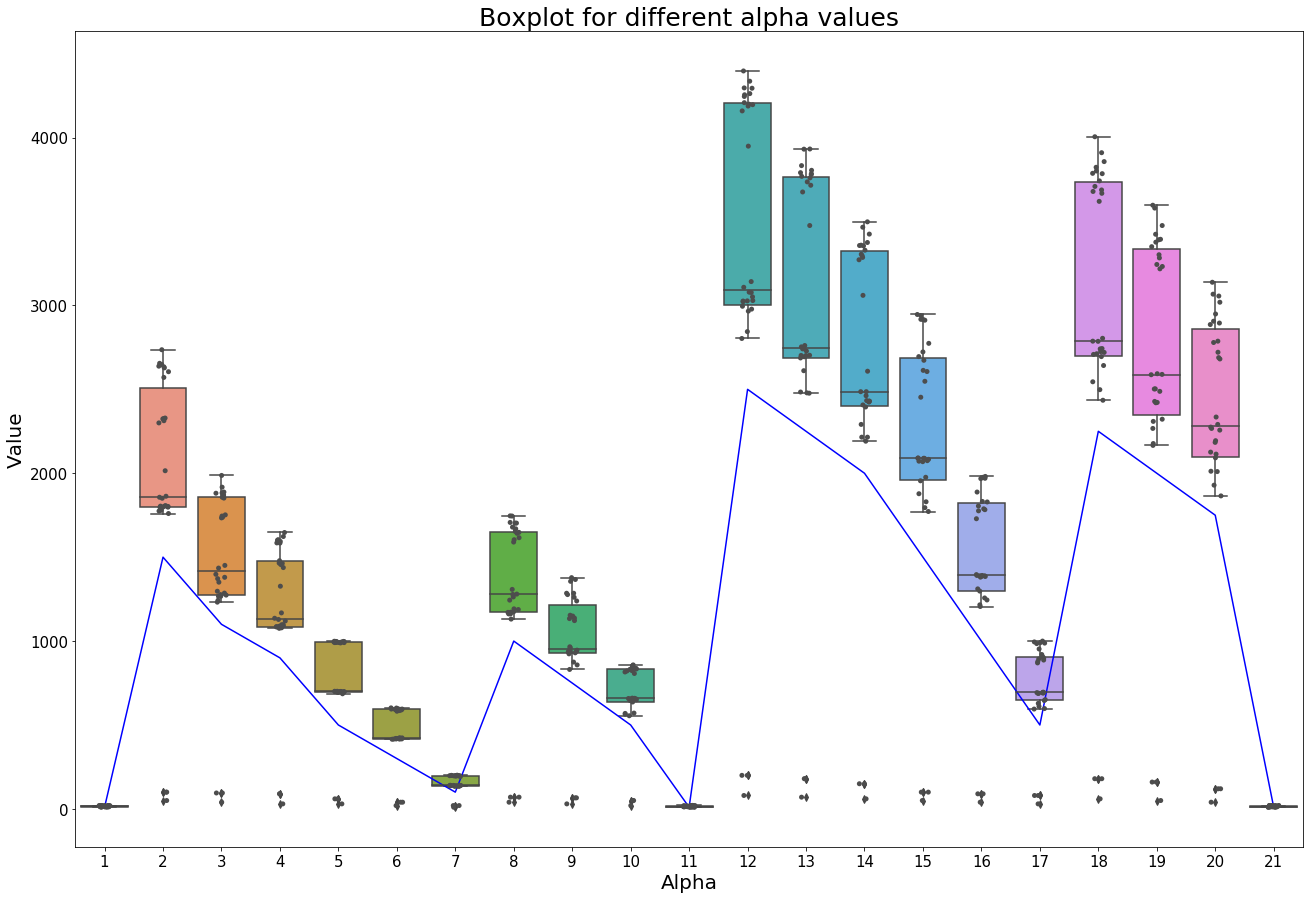

In [335]:
# construct final alpha dataframe
final_alpha_df = pd.DataFrame(final_alpha_list, columns=alpha_name_list)

fig, ax = plt.subplots(figsize = (22,15))
sns.boxplot(data=final_alpha_df)
sns.stripplot(data=final_alpha_df, color=".3", size=5)

locs=ax.get_xticks()
ax.plot(locs, alpha_init, 'b-')

# label
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Value', fontsize = 20)
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.title('Boxplot for different alpha values', fontsize = 25) 
fig.savefig("Boxplot for different alpha values")

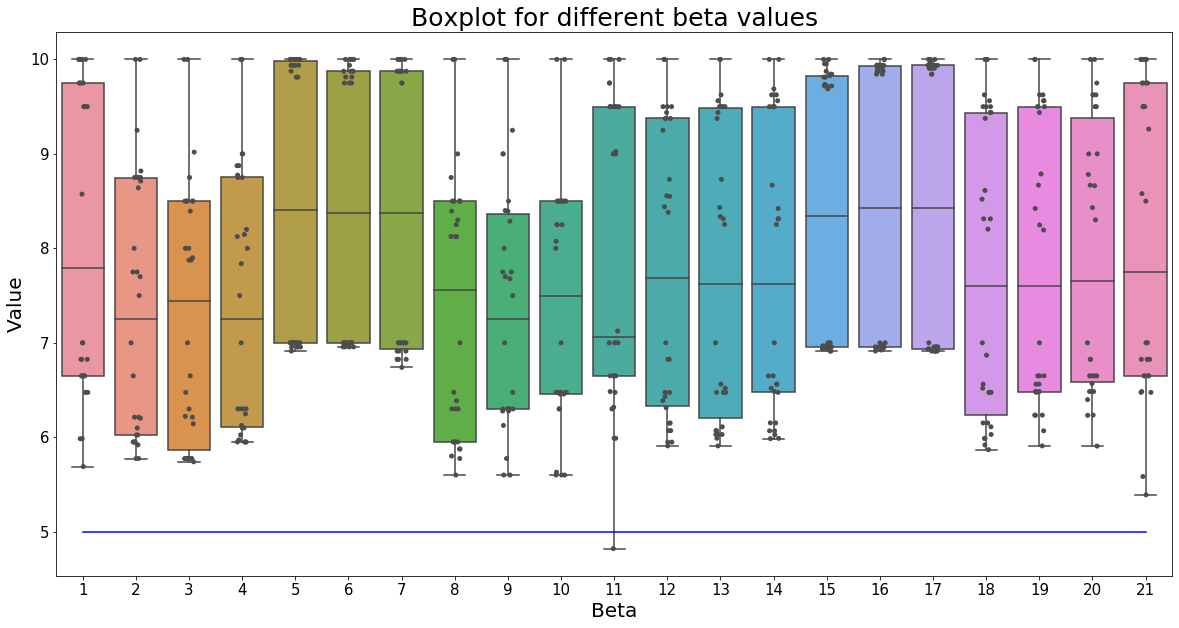

In [336]:
# construct final beta dataframe
final_beta_df = pd.DataFrame(final_beta_list, columns=beta_name_list)

fig, ax = plt.subplots(figsize = (20,10))
sns.boxplot(data=final_beta_df)
sns.stripplot(data=final_beta_df, color=".3", size=5)

locs=ax.get_xticks()
ax.plot(locs, beta_init, 'b-')

# label
plt.xlabel('Beta', fontsize = 20)
plt.ylabel('Value', fontsize = 20)
#plt.rc('xtick',labelsize = 12)
#plt.rc('ytick',labelsize = 12)
plt.title('Boxplot for different beta values', fontsize = 25) 
fig.savefig("Boxplot for different beta values")

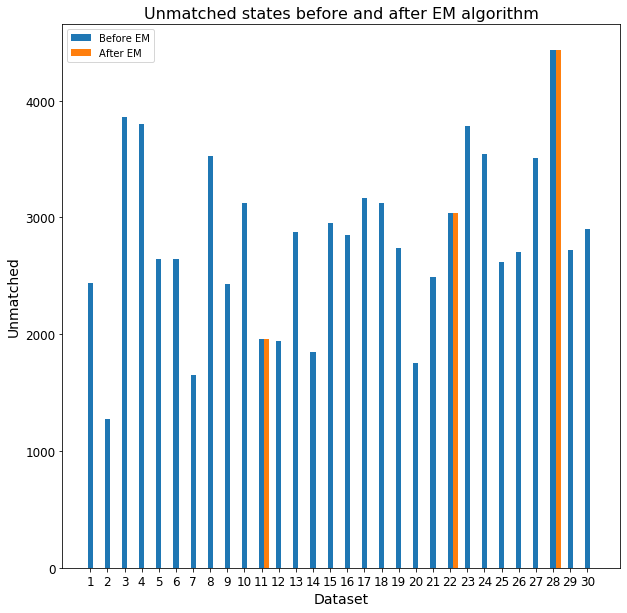

In [340]:
# plot
fig, ax = plt.subplots(figsize = (10,10))
plt.xticks(np.arange(1, 31, 1))
ind = np.arange(1, 31, 1)
width = 0.3

# label
plt.bar(ind, before, width, label = 'Before EM')
plt.bar(ind + width, after, width, label = 'After EM') 
plt.xlabel('Dataset', fontsize = 14)
plt.ylabel('Unmatched', fontsize = 14)
plt.rc('xtick',labelsize = 12)
plt.rc('ytick',labelsize = 12)
plt.title('Unmatched states before and after EM algorithm', fontsize = 16) 
plt.legend(loc = 'best')
fig.savefig("Unmatched states before and after EM algorithm")

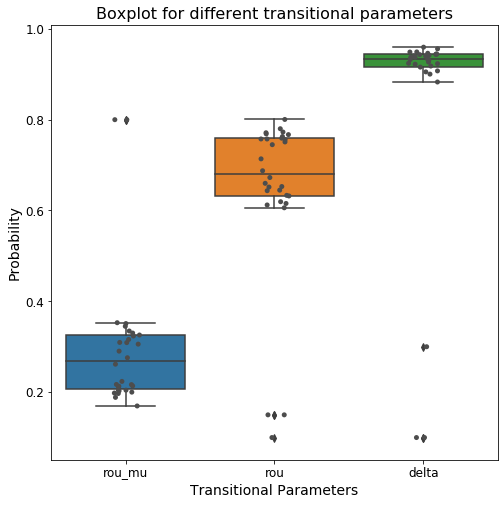

In [341]:
rou_mu = []
rou = []
delta = []
for element in final_trans:
    rou_mu.append(element['AUG'][0])
    rou.append(element['AUG'][1])
    delta.append(element['AUG'][2])
    
final_trans_df = pd.DataFrame({"rou_mu":rou_mu, "rou":rou,"delta": delta}, 
                                         columns=['rou_mu', 'rou', 'delta'])

fig, ax = plt.subplots(figsize = (8, 8))
sns.boxplot(data=final_trans_df)
sns.stripplot(data=final_trans_df, color=".3", size=5)


plt.xlabel('Transitional Parameters', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
plt.title('Boxplot for different transitional parameters', fontsize = 16) 
fig.savefig("Boxplot for different transitional parameters")



# beta fixed

In [55]:
def EM_iter(RNA_data, observed_data, trans_init, alpha_init, beta_init, epsilon, max_iter):
    
    trans = trans_init.copy()
    alpha_list = alpha_init.copy()
    beta_list = beta_init
    #beta_list = beta_init.copy()
    
    forward = forward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)
    backward = backward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)  
    
    log_links = []
    log_links.append(incomplete_log_likelihood(forward, observed_data, alpha_list, beta_list, E))
    
    delta = 1
    n_iter = 1
    print(log_links)
    while((delta > epsilon) and (n_iter < max_iter)):
        print("iteration" + str(n_iter))
        #forward = forward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)
        #backward = backward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)
        curr_trans = trans.copy()
        curr_alpha_list = alpha_list.copy()
        #curr_beta_list = beta_list.copy()
       
        L = compute_L(forward, backward)
        
        #update rho_u_ci, rho_ci, delta_ci
        trans = update_three_parameters(forward, backward, RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)
        print(trans)
        
        # alpha_list
        state_list = np.arange(21)+1
        random.shuffle(state_list)
        
        for i in state_list:
            state = i
           
            print("state"+str(state))
            res = minimize(object_function_alpha, alpha_list[state-1], method='BFGS', tol = 1, jac=derivative_function_alpha, args = (state, forward, observed_data, beta_list, E, L), options={'disp': False, 'maxiter': 10,'gtol': 1})
            alpha_list[state-1] = res.x[0]
            print("alpha"+str(res.x[0]))
            
            #res = minimize(object_function_beta, beta_list[state-1], method='nelder-mead', tol = 1, args = (state, forward, observed_data, alpha_list, E, L), options={'disp': False})
            #beta_list[state-1] = res.x[0]
            #print("beta"+str(res.x[0]))
           
            
        
        print(alpha_list)
        #print(beta_list)

        
        forward = forward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)
        backward = backward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)  
        
        # log likelihood
        log_links.append(incomplete_log_likelihood(forward, observed_data, alpha_list, beta_list, E))
        delta = log_links[-1] - log_links[-2]
        n_iter += 1
        
        print(log_links)


    if (delta < 0):
        trans = curr_trans
        alpha_list = curr_alpha_list
        #beta_list = curr_beta_list
        
    return (trans, alpha_list)
    


In [56]:
trans_prob = [{'AUG': [0.2, 0.1, 0.3], 'CUG': [0.4, 0.2, 0.3], 'GUG': [0.2, 0.2, 0.3]}, {'AUG': [0.5, 0.2, 0.7], 'CUG':[0.4, 0.2, 0.2], 'GUG': [0.1, 0.3, 0.6]}, {'AUG': [0.8, 0.15, 0.1], 'CUG': [0.6, 0.2, 0.1], 'GUG': [0.2, 0.15, 0.3]}, {'AUG': [0.42, 0.42, 0.5], 'CUG': [0.5, 0.1, 0.2], 'GUG': [0.1, 0.1, 0.1]}]
alpha_list_prob = [np.array([10, 50, 40, 30, 30, 20, 10, 40 , 30, 20, 10, 80, 70, 60, 50, 40 , 30, 60, 50 , 40 , 10]),
            np.array([  100, 250, 220, 200, 150, 100,  50, 220, 200, 170,100, 500, 450, 420, 400, 350, 300, 400, 380, 360, 100]),
            np.array([ 1, 5, 4, 3,  4,  3, 2, 5, 4, 3, 10, 1, 9, 8, 7, 6, 5, 9, 8, 7, 2])]

In [57]:
final_trans_beta_fixed = []
final_alpha_list_beta_fixed = []
#final_beta_list = []

start_trans_beta_fixed = []
start_alpha_list_beta_fixed = []
#start_beta_list = []

start = 0
count = 1
for end in range(100, 3001, 100):
    print("count " + str(count))
    
    trans_prob_copy = trans_prob.copy()
    # randomly generate index for trans
    random.seed(end)
    index = random.choice(range(4))
    trans = trans_prob_copy[index]
    start_trans_beta_fixed.append(trans)
    
    # randomly generate index for alpha_list
    random.seed(end+1)
    index = random.choice(range(3))
    alpha_list = alpha_list_prob[index]
    start_alpha_list_beta_fixed.append(alpha_list)
    
    # randomly generate index for beta_list
    #random.seed(end+2)
    #index = random.choice(range(2))
    #beta_list = beta_list_prob[index]
    #start_beta_list.append(beta_list)
    
    # run EM algorithm
    trans_copy = trans.copy()
    alpha_list_copy = alpha_list.copy()
    #beta_list_copy = beta_list.copy()
    
    temp = EM_iter(RNA_data[start:end], observed_data[start:end], trans_copy, alpha_list_copy, beta_list_true, 10e-10, 100)
    final_trans_beta_fixed.append(temp[0])
    final_alpha_list_beta_fixed.append(temp[1])
    #final_beta_list.append(temp[2])
    
    start = end
    
    count += 1

count 1
[-6185.826476840469]
iteration1
defaultdict(<class 'list'>, {'AUG': [0.5820290849559914, 0.4134384373379753, 3.9561437253745476e-16], 'CUG': [0.5686515060224208, 0.41987141179767007, 5.560273947684028e-17], 'GUG': [0.5331221523830367, 0.4539065531799224, 1.4515672087667631e-19]})
state11
alpha768.2332846864701
state16
alpha1060.9609585615322
state13
alpha1243.892166335998
state1
alpha346.6119169551648
state20
alpha1160.0514029074438
state9
alpha1074.166960922448
state3
alpha1102.237292876696
state17
alpha579.9790998460074
state19
alpha1250.6020077137707
state6
alpha732.1609426483461
state14
alpha1011.0824875608062
state8
alpha1364.7668473337437
state5
alpha953.9703652110384
state4
alpha1050.079631053776
state10
alpha1032.9488018992784
state21
alpha343.6104836542394
state2
alpha1248.76639377974
state15
alpha1025.4374895269366
state12
alpha967.9921285430589
state18
alpha1767.8458612390677
state7
alpha483.56924184961247
[ 346 1248 1102 1050  953  732  483 1364 1074 1032  768  967 

defaultdict(<class 'list'>, {'AUG': [0.04794584322371526, 0.7271346324767537, 0.9397960894905116], 'CUG': [0.056470772921543504, 0.7134802678514529, 0.9290953545230898], 'GUG': [0.03155810331128886, 0.7201743393652209, 0.92840247947092]})
state21
alpha398.5773962685034
state12
alpha1598.8163172955615
state6
alpha744.559458748392
state20
alpha1371.4904370622062
state1
alpha598.268100857891
state10
alpha921.5771072165677
state7
alpha595.1823360384823
state19
alpha1577.0908873845267
state2
alpha1435.6453428021928
state15
alpha1121.951810023573
state8
alpha1318.1325240322728
state17
alpha566.9348252155675
state18
alpha1923.3653816521846
state5
alpha996.8812662920543
state3
alpha1272.7395051270414
state11
alpha393.88250674750947
state16
alpha1070.5372305539543
state13
alpha1472.244869704707
state9
alpha1088.8086380533214
state14
alpha1175.33124075963
state4
alpha1098.249121902837
[ 598 1435 1272 1098  996  744  595 1318 1088  921  393 1598 1472 1175
 1121 1070  566 1923 1577 1371  398]
[-17

alpha1595.8499999999983
state19
alpha1601.6275809036847
state5
alpha997.2269977000352
state3
alpha1355.2100000000007
state16
alpha1147.3865252678695
state17
alpha500.61553350446246
state6
alpha750.0355335144661
state20
alpha1562.940351254627
state14
alpha1467.438224997064
state10
alpha1046.0
state4
alpha1213.0513201368506
state7
alpha598.2671176298845
state12
alpha2059.312493240459
state1
alpha399.0
state11
alpha400.388335790819
state15
alpha1245.5572716068427
state21
alpha400.01
state8
alpha1425.0
state13
alpha1855.7483121525383
state9
alpha1153.0
state18
alpha1968.8499999999997
[ 399 1595 1355 1213  997  750  598 1425 1153 1046  400 2059 1855 1467
 1245 1147  500 1968 1601 1562  400]
[-4638.108752775217, -151.82659309723118, -151.82659309723118]
count 7
[-8098.394572832688]
iteration1
defaultdict(<class 'list'>, {'AUG': [0.5482793418839985, 0.44433513374307665, 1.2231413254668779e-20], 'CUG': [0.5356445595132614, 0.4538459485570565, 1.185101444116064e-21], 'GUG': [0.5362433108596691,

alpha401.0
state13
alpha1926.0
state1
alpha399.0
state17
alpha500.4823813142189
state18
alpha1991.0
state5
alpha995.0
state3
alpha1449.0
state7
alpha601.0
state16
alpha1146.9101022968903
state10
alpha1063.0
state19
alpha1609.2100000000003
state15
alpha1247.2075042338377
state21
alpha399.0
state6
alpha746.0099999999995
state12
alpha2146.0
state14
alpha1412.0
state4
alpha1204.0
state8
alpha1573.0
state9
alpha1193.0
state2
alpha1690.0
state20
alpha1535.0
[ 399 1690 1449 1204  995  746  601 1573 1193 1063  401 2146 1926 1412
 1247 1146  500 1991 1609 1535  399]
[-1689.7953732837614, -341.0406887384516, -151.03318291081848, -151.03318291081848]
count 10
[-5485.106250137712]
iteration1
defaultdict(<class 'list'>, {'AUG': [0.25343508522677644, 0.6738237041126338, 0.9035671773148515], 'CUG': [0.23636640546244458, 0.6743147408301519, 0.8512585713512797], 'GUG': [0.2166241192473609, 0.6855893474244145, 0.8598903199680956]})
state5
alpha1003.6714168531253
state15
alpha1053.7431957565136
state20
a

alpha1483.4174097038226
state4
alpha1141.673682242217
state18
alpha2001.8500000000029
state21
alpha398.0
state11
alpha400.00275568241256
state9
alpha1172.0
state1
alpha398.0
state15
alpha1249.1942584998192
state13
alpha1843.7948316060724
state10
alpha1019.0
[ 398 1718 1356 1141  998  751  596 1469 1172 1019  400 2083 1843 1455
 1249 1147  499 2001 1642 1483  398]
[-4746.379746691855, -144.05770600371335, -144.05770600371335]
count 13
[-2768.329940955977]
iteration1
defaultdict(<class 'list'>, {'AUG': [0.06354816361534316, 0.725901175754162, 0.9211746522411], 'CUG': [0.054449000673825576, 0.7500958437811966, 0.9291738156412749], 'GUG': [0.037074381471930026, 0.7131059724913736, 0.8954543534589855]})
state15
alpha1123.566210359237
state5
alpha999.8671499313854
state14
alpha1165.9315894545177
state12
alpha1602.4035371011962
state13
alpha1442.7682095930754
state20
alpha1489.0913897960427
state3
alpha1285.3515346510053
state7
alpha599.9366476302148
state19
alpha1609.6203092037968
state10
al

alpha398.73375771963396
state19
alpha1637.4418644703987
state5
alpha1000.1382831857136
state20
alpha1443.6176272580726
state14
alpha1429.510832682435
state4
alpha1120.968491112192
state8
alpha1440.2099999999996
state12
alpha2105.870044552964
[ 398 1546 1417 1120 1000  749  600 1440 1101 1042  399 2105 1887 1429
 1214 1099  512 2031 1637 1443  401]
[-6189.227674222132, -192.7685155207684, -154.5558648920904]
iteration3
defaultdict(<class 'list'>, {'AUG': [0.3417099270573279, 0.5990917216869671, 0.8899082568807339], 'CUG': [0.33217394514560367, 0.5810679382309001, 0.8608490566037722], 'GUG': [0.3170063853187665, 0.5743637602330834, 0.8318385650224216]})
state10
alpha1042.0
state13
alpha1887.0
state12
alpha2105.0
state5
alpha1000.0
state8
alpha1507.290204732149
state20
alpha1510.834793054164
state15
alpha1245.7644664858176
state14
alpha1429.0
state4
alpha1141.21
state18
alpha2031.0
state11
alpha401.81353026016103
state6
alpha749.0
state9
alpha1122.21
state21
alpha401.0
state17
alpha499.71

alpha399.35661216645957
state9
alpha1167.364497903106
state21
alpha398.18399079557236
[ 399 1571 1378 1162  999  743  594 1440 1167 1014  400 1439 1313 1060
 1161 1098  554 1953 1617 1460  398]
[-6401.043083213005, -191.58134677730567]
iteration2
defaultdict(<class 'list'>, {'AUG': [0.3032945405107184, 0.6556779693129293, 0.9162112932604736], 'CUG': [0.30455232931914145, 0.6196881534875499, 0.8270893371757926], 'GUG': [0.2940457462660765, 0.5916232751286742, 0.784741144414169]})
state14
alpha1466.125313381631
state6
alpha751.2593934197109
state20
alpha1481.2099999999994
state18
alpha2020.0150205643145
state5
alpha1002.2471908402612
state7
alpha597.2656393935073
state9
alpha1167.0
state15
alpha1249.8012847111377
state10
alpha1014.0
state16
alpha1149.653904683442
state1
alpha399.0
state8
alpha1440.0
state13
alpha1889.7555171915278
state12
alpha2083.649396107088
state21
alpha398.0
state11
alpha400.0
state4
alpha1162.0
state3
alpha1378.0
state17
alpha501.05536714915985
state2
alpha1592.143

alpha955.1737753218771
state9
alpha1146.715016133486
state2
alpha1267.0275574240986
state6
alpha731.7131302535508
state12
alpha985.7171861576705
[ 345 1267 1122  976  955  731  476 1413 1146 1053  803  985 1519 1047
 1105 1089  551 1812 1539 1444  348]
[-6201.7699905067275, -186.02713766415116]
iteration2
defaultdict(<class 'list'>, {'AUG': [0.273972611566945, 0.6760273972602714, 0.880076976729993], 'CUG': [0.2802395673309358, 0.6464456771317116, 0.8635545755563323], 'GUG': [0.24239313080177396, 0.649658150963792, 0.8085579687556357]})
state7
alpha598.8896166721072
state1
alpha398.43675836811605
state17
alpha507.5493571794831
state21
alpha399.10599501366613
state16
alpha1115.997887912081
state4
alpha1209.0306868302118
state2
alpha1702.5665467360022
state3
alpha1414.1121815087192
state14
alpha1440.6861117003318
state11
alpha399.7225562898855
state5
alpha1001.9972524822953
state18
alpha2042.1381619529475
state13
alpha1921.733072841879
state9
alpha1146.0
state8
alpha1480.0739443257355
sta

alpha590.0385412369707
[ 399 1471 1314 1096  994  744  590 1455 1182 1027  394 1302 1188  968
 1059 1090  622 1859 1520 1378  399]
[-5001.532131743261, -155.75195054190155]
iteration2
defaultdict(<class 'list'>, {'AUG': [0.3141117389621176, 0.6292977521724135, 0.9005524861878452], 'CUG': [0.34067137338779063, 0.5865608221751374, 0.855191256830601], 'GUG': [0.2899997946977069, 0.5777215804902296, 0.7869265663667723]})
state10
alpha1027.0
state21
alpha400.0100000000002
state6
alpha752.2356915056063
state17
alpha501.1151866753729
state9
alpha1182.0
state3
alpha1380.9985922191233
state20
alpha1551.594662133245
state18
alpha2125.4432230657485
state4
alpha1117.2099999999991
state19
alpha1691.7955687444176
state14
alpha1432.1352402320567
state5
alpha997.2790772499089
state7
alpha597.5059549283875
state8
alpha1476.1932627904762
state11
alpha400.39054408471895
state15
alpha1245.7166766618886
state13
alpha1956.2632580846748
state12
alpha2176.804028372397
state1
alpha399.0
state2
alpha1704.108102

[-1886.0511657904624, -346.1358911125173]
iteration2
defaultdict(<class 'list'>, {'AUG': [0.21141576768087747, 0.7087955286062337, 0.83525636869123], 'CUG': [0.17242134920885036, 0.7196576363475768, 0.797517544159834], 'GUG': [0.18554182837472696, 0.6553780401477446, 0.7671235290693297]})
state16
alpha1086.3217291802782
state4
alpha1123.0
state17
alpha516.1192429595206
state18
alpha1899.0
state1
alpha401.00464173032765
state19
alpha1588.0
state2
alpha1626.7236350808514
state6
alpha748.0
state12
alpha2094.570068756799
state7
alpha602.8032211234539
state8
alpha1371.8499999999972
state20
alpha1393.21
state14
alpha1403.8268814374564
state5
alpha999.1911516425381
state9
alpha1111.0
state13
alpha1856.8300350514858
state21
alpha401.00999999999937
state15
alpha1209.7580356847923
state11
alpha401.0374541012091
state3
alpha1477.1971804049504
state10
alpha1022.0
[ 401 1626 1477 1123  999  748  602 1371 1111 1022  401 2094 1856 1403
 1209 1086  516 1899 1588 1393  401]
[-1886.0511657904624, -346.1

defaultdict(<class 'list'>, {'AUG': [0.19276252851724635, 0.7350184441994695, 0.8906249999998913], 'CUG': [0.18730024215734317, 0.6956506567473023, 0.7923322683698734], 'GUG': [0.18250966322571632, 0.6824298321650079, 0.7867434894132158]})
state11
alpha406.6691257146206
state17
alpha512.3706716824606
state18
alpha1911.0
state3
alpha1291.0078552629452
state2
alpha1661.0582940413433
state12
alpha2095.1860297348267
state16
alpha1102.9155955040799
state10
alpha944.2100000000003
state5
alpha997.0
state13
alpha1893.8456725811932
state4
alpha1193.760472963301
state8
alpha1414.8499999999963
state19
alpha1569.0
state1
alpha400.20603946481936
state7
alpha599.0
state20
alpha1445.316541226608
state14
alpha1394.3282174740123
state9
alpha1211.6860760000357
state6
alpha748.0
state21
alpha399.0
state15
alpha1224.0067846297802
[ 400 1661 1291 1193  997  748  599 1414 1211  944  406 2095 1893 1394
 1224 1102  512 1911 1569 1445  399]
[-1757.7576017418448, -340.81730683447483, -159.02373317926708]
iterat

In [58]:
final_trans_beta_fixed

[defaultdict(list,
             {'AUG': [0.39713664229362383,
               0.5460357149728641,
               0.8637866474307427],
              'CUG': [0.3675350583420811,
               0.5476434137017753,
               0.8430493273542597],
              'GUG': [0.35763867007688743,
               0.5173159018920085,
               0.7839080459770115]}),
 defaultdict(list,
             {'AUG': [0.3534666142414296,
               0.5872072955950853,
               0.8581566389557123],
              'CUG': [0.3374135435687552,
               0.5901064386149586,
               0.8541666666627709],
              'GUG': [0.31668548274657554,
               0.5754824935051946,
               0.8084577114426827]}),
 defaultdict(list,
             {'AUG': [0.34818636800089053,
               0.5942829727725021,
               0.8427672917974934],
              'CUG': [0.3603034787755641,
               0.5684486370758024,
               0.8613138621363282],
              'GUG': [0.3178450

In [59]:
final_alpha_list_beta_fixed

[array([ 400, 1707, 1391, 1184, 1000,  751,  601, 1516, 1163, 1032,  400,
        2090, 1848, 1402, 1250, 1151,  499, 1992, 1714, 1492,  398]),
 array([ 400, 1599, 1376, 1170,  995,  748,  597, 1448, 1151, 1022,  401,
        2124, 1873, 1374, 1249, 1144,  499, 1988, 1646, 1481,  398]),
 array([ 402, 1733, 1427, 1172,  999,  750,  601, 1566, 1179, 1012,  403,
        2132, 1937, 1427, 1247, 1148,  501, 1996, 1632, 1539,  401]),
 array([ 403, 1714, 1445, 1165,  997,  747,  598, 1569, 1156, 1093,  400,
        2154, 1958, 1460, 1249, 1151,  501, 1989, 1644, 1542,  398]),
 array([ 400, 1698, 1405, 1185,  995,  749,  599, 1511, 1167, 1055,  401,
        2094, 1837, 1401, 1248, 1151,  501, 1981, 1637, 1520,  399]),
 array([ 399, 1595, 1355, 1213,  997,  750,  598, 1425, 1153, 1046,  400,
        2059, 1855, 1467, 1245, 1147,  500, 1968, 1601, 1562,  400]),
 array([ 398, 1621, 1463, 1171,  998,  746,  601, 1509, 1192, 1025,  401,
        2096, 1853, 1418, 1248, 1150,  498, 2000, 1611, 1511, 

In [60]:
start_trans_beta_fixed

[{'AUG': [0.5, 0.2, 0.7], 'CUG': [0.4, 0.2, 0.2], 'GUG': [0.1, 0.3, 0.6]},
 {'AUG': [0.2, 0.1, 0.3], 'CUG': [0.4, 0.2, 0.3], 'GUG': [0.2, 0.2, 0.3]},
 {'AUG': [0.8, 0.15, 0.1], 'CUG': [0.6, 0.2, 0.1], 'GUG': [0.2, 0.15, 0.3]},
 {'AUG': [0.8, 0.15, 0.1], 'CUG': [0.6, 0.2, 0.1], 'GUG': [0.2, 0.15, 0.3]},
 {'AUG': [0.42, 0.42, 0.5], 'CUG': [0.5, 0.1, 0.2], 'GUG': [0.1, 0.1, 0.1]},
 {'AUG': [0.8, 0.15, 0.1], 'CUG': [0.6, 0.2, 0.1], 'GUG': [0.2, 0.15, 0.3]},
 {'AUG': [0.5, 0.2, 0.7], 'CUG': [0.4, 0.2, 0.2], 'GUG': [0.1, 0.3, 0.6]},
 {'AUG': [0.42, 0.42, 0.5], 'CUG': [0.5, 0.1, 0.2], 'GUG': [0.1, 0.1, 0.1]},
 {'AUG': [0.5, 0.2, 0.7], 'CUG': [0.4, 0.2, 0.2], 'GUG': [0.1, 0.3, 0.6]},
 {'AUG': [0.42, 0.42, 0.5], 'CUG': [0.5, 0.1, 0.2], 'GUG': [0.1, 0.1, 0.1]},
 {'AUG': [0.2, 0.1, 0.3], 'CUG': [0.4, 0.2, 0.3], 'GUG': [0.2, 0.2, 0.3]},
 {'AUG': [0.8, 0.15, 0.1], 'CUG': [0.6, 0.2, 0.1], 'GUG': [0.2, 0.15, 0.3]},
 {'AUG': [0.8, 0.15, 0.1], 'CUG': [0.6, 0.2, 0.1], 'GUG': [0.2, 0.15, 0.3]},
 {'AUG': 

In [61]:
start_alpha_list_beta_fixed

[array([ 1,  5,  4,  3,  4,  3,  2,  5,  4,  3, 10,  1,  9,  8,  7,  6,  5,
         9,  8,  7,  2]),
 array([10, 50, 40, 30, 30, 20, 10, 40, 30, 20, 10, 80, 70, 60, 50, 40, 30,
        60, 50, 40, 10]),
 array([100, 250, 220, 200, 150, 100,  50, 220, 200, 170, 100, 500, 450,
        420, 400, 350, 300, 400, 380, 360, 100]),
 array([100, 250, 220, 200, 150, 100,  50, 220, 200, 170, 100, 500, 450,
        420, 400, 350, 300, 400, 380, 360, 100]),
 array([ 1,  5,  4,  3,  4,  3,  2,  5,  4,  3, 10,  1,  9,  8,  7,  6,  5,
         9,  8,  7,  2]),
 array([10, 50, 40, 30, 30, 20, 10, 40, 30, 20, 10, 80, 70, 60, 50, 40, 30,
        60, 50, 40, 10]),
 array([ 1,  5,  4,  3,  4,  3,  2,  5,  4,  3, 10,  1,  9,  8,  7,  6,  5,
         9,  8,  7,  2]),
 array([10, 50, 40, 30, 30, 20, 10, 40, 30, 20, 10, 80, 70, 60, 50, 40, 30,
        60, 50, 40, 10]),
 array([100, 250, 220, 200, 150, 100,  50, 220, 200, 170, 100, 500, 450,
        420, 400, 350, 300, 400, 380, 360, 100]),
 array([10, 50, 40,

# boxplot for alpha

Text(0.5, 1.0, 'Boxplot for different alpha values')

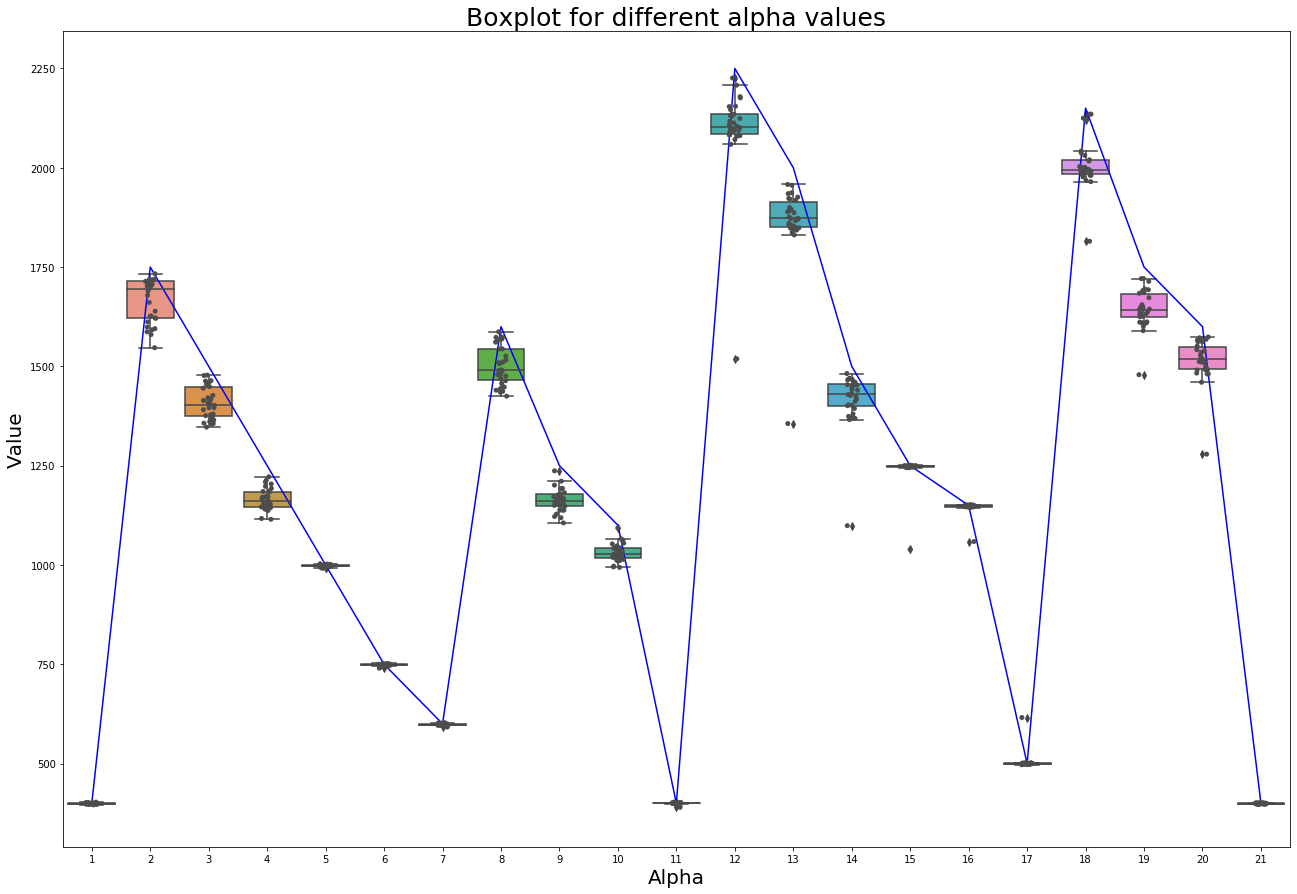

In [63]:
alpha_name_list = []
for i in range(1, 22):
    alpha_name_list.append(str(i))
    

final_alpha_df_beta_fixed = pd.DataFrame(final_alpha_list_beta_fixed, columns=alpha_name_list)


fig, ax = plt.subplots(figsize = (22,15))
sns.boxplot(data=final_alpha_df_beta_fixed)
sns.stripplot(data=final_alpha_df_beta_fixed, color = '.3', size = 5)

locs=ax.get_xticks()
ax.plot(locs, alpha_list_true, 'b-')

plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Value', fontsize = 20)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
plt.title('Boxplot for different alpha values', fontsize = 25) 
fig.savefig("Boxplot for different alpha values with beta fixed")

# boxplot for tran

Text(0.5, 1.0, 'AUG: Boxplot for different transitional parameters with beta fixed')

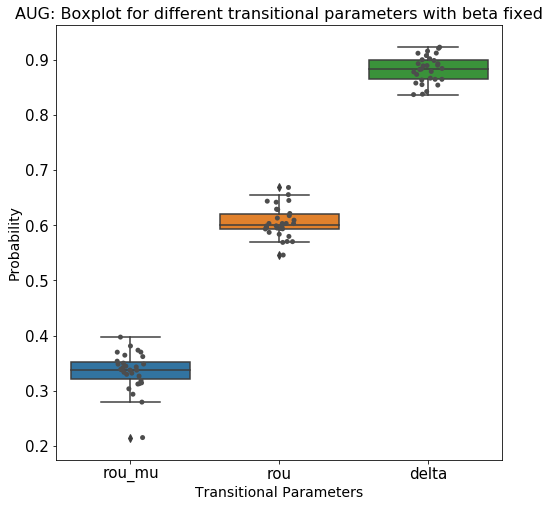

In [65]:
rou_mu_beta_fixed = []
rou_beta_fixed = []
delta_beta_fixed = []
for element in final_trans_beta_fixed:
    rou_mu_beta_fixed.append(element['AUG'][0])
    rou_beta_fixed.append(element['AUG'][1])
    delta_beta_fixed.append(element['AUG'][2])
    
final_trans_df_beta_fixed = pd.DataFrame({"rou_mu":rou_mu_beta_fixed, "rou":rou_beta_fixed,"delta": delta_beta_fixed}, 
                                         columns=['rou_mu', 'rou', 'delta'])

fig, ax = plt.subplots(figsize = (8, 8))
sns.boxplot(data=final_trans_df_beta_fixed)
sns.stripplot(data=final_trans_df_beta_fixed, color=".3", size=5)


plt.xlabel('Transitional Parameters', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
plt.rc('xtick', labelsize = 12)
plt.rc('ytick', labelsize = 12)
plt.title('AUG: Boxplot for different transitional parameters with beta fixed', fontsize = 16) 
fig.savefig("Boxplot for different transitional parameters with beta fixed")



Text(0.5, 1.0, 'CUG: Boxplot for different transitional parameters with beta fixed')

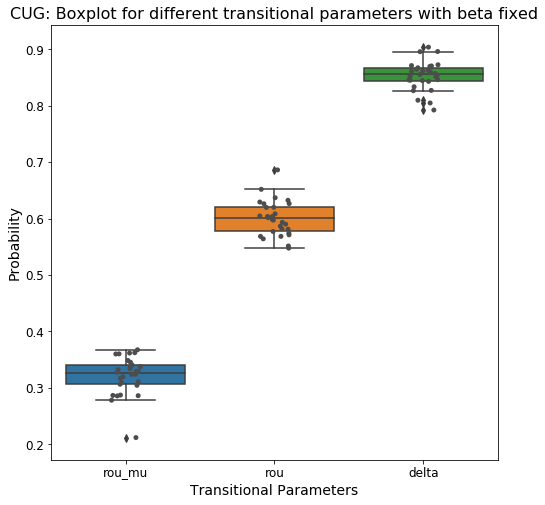

In [66]:
rou_mu_beta_fixed = []
rou_beta_fixed = []
delta_beta_fixed = []
for element in final_trans_beta_fixed:
    rou_mu_beta_fixed.append(element['CUG'][0])
    rou_beta_fixed.append(element['CUG'][1])
    delta_beta_fixed.append(element['CUG'][2])
    
final_trans_df_beta_fixed = pd.DataFrame({"rou_mu":rou_mu_beta_fixed, "rou":rou_beta_fixed,"delta": delta_beta_fixed}, 
                                         columns=['rou_mu', 'rou', 'delta'])

fig, ax = plt.subplots(figsize = (8, 8))
sns.boxplot(data=final_trans_df_beta_fixed)
sns.stripplot(data=final_trans_df_beta_fixed, color=".3", size=5)


plt.xlabel('Transitional Parameters', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
plt.rc('xtick', labelsize = 12)
plt.rc('ytick', labelsize = 12)
plt.title('CUG: Boxplot for different transitional parameters with beta fixed', fontsize = 16) 
#fig.savefig("Boxplot for different transitional parameters with beta fixed")



Text(0.5, 1.0, 'GUG: Boxplot for different transitional parameters with beta fixed')

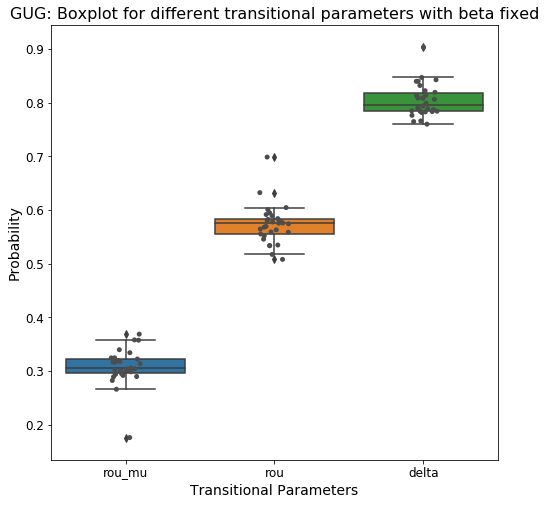

In [67]:
rou_mu_beta_fixed = []
rou_beta_fixed = []
delta_beta_fixed = []
for element in final_trans_beta_fixed:
    rou_mu_beta_fixed.append(element['GUG'][0])
    rou_beta_fixed.append(element['GUG'][1])
    delta_beta_fixed.append(element['GUG'][2])
    
final_trans_df_beta_fixed = pd.DataFrame({"rou_mu":rou_mu_beta_fixed, "rou":rou_beta_fixed,"delta": delta_beta_fixed}, 
                                         columns=['rou_mu', 'rou', 'delta'])

fig, ax = plt.subplots(figsize = (8, 8))
sns.boxplot(data=final_trans_df_beta_fixed)
sns.stripplot(data=final_trans_df_beta_fixed, color=".3", size=5)


plt.xlabel('Transitional Parameters', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
plt.rc('xtick', labelsize = 12)
plt.rc('ytick', labelsize = 12)
plt.title('GUG: Boxplot for different transitional parameters with beta fixed', fontsize = 16) 
#fig.savefig("Boxplot for different transitional parameters with beta fixed")



# unmatched num

In [68]:
beta_list_beta_fixed = np.repeat([beta_list_true],30, axis = 1).reshape(30,21)

In [83]:
before_beta_fixed = differ_state(RNA_data, observed_data, start_alpha_list_beta_fixed, beta_list_beta_fixed, E, start_trans_beta_fixed, stop_codon_list, state_list_true)
after_beta_fixed = differ_state(RNA_data, observed_data, final_alpha_list_beta_fixed, beta_list_beta_fixed, E, final_trans_beta_fixed, stop_codon_list, state_list_true)




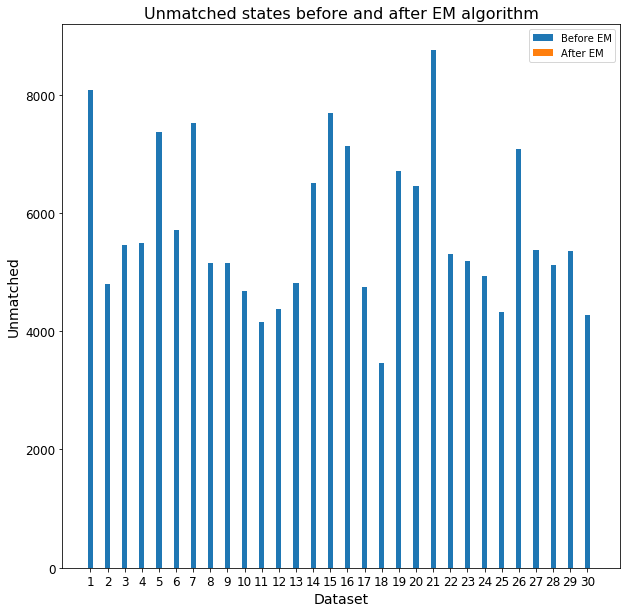

In [86]:
fig, ax = plt.subplots(figsize = (10,10))
plt.xticks(np.arange(1, 31, 1))
ind = np.arange(1, 31, 1)
width = 0.3
plt.bar(ind, before_beta_fixed, width, label = 'Before EM')
plt.bar(ind + width, after_beta_fixed, width, label = 'After EM') 
plt.xlabel('Dataset', fontsize = 14)
plt.ylabel('Unmatched', fontsize = 14)
plt.title('Unmatched states before and after EM algorithm', fontsize = 16) 
plt.legend(loc = 'best')
fig.savefig("Unmatched states before and after EM algorithm with beta fixed")

In [87]:
after_beta_fixed

[2,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 4,
 2,
 0,
 0,
 0,
 0]

In [88]:
def percent(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, viterbi_truth, state_list_true, specific_codon):

    start = 0
    output_list = []
    output_codon_num = []
    
    for end in range(100, 3000, 100): #GAI
        
        if viterbi_truth == True:
            viterbi_output = viterbi_sequence(RNA_data[start:end], observed_data[start:end], 
                                          alpha_list[int(start/100)], beta_list[int(start/100)], 
                                          E, trans[int(start/100)], stop_codon_list) #GAI  
        else:
            viterbi_output = state_list_true[start:end]
        
        
        codon_num_list = []
        actual_start_list = []
        for sequence_num in range(len(viterbi_output)):
            start_codon = 0
            actual_start = 0
            starts = [j for j, x in enumerate(viterbi_output[sequence_num]) if x == 10]
            ends = [j for j, x in enumerate(viterbi_output[sequence_num]) if x == 2]
            
            for position in ends:
                if RNA_data[start+sequence_num][position] == specific_codon[0]:
                    actual_start += 1
            actual_start_list.append(actual_start)
            
            starts.insert(0, -1)

            if len(ends) == 0:
                ends.append(len(viterbi_output[sequence_num]) - 4)
                
            pairs = []
            for i in range(len(ends)):
                pairs.append((starts[i]+1, ends[i]))

            for pair in pairs:
                for i in range(pair[0], pair[1]+1):
                    codon = RNA_data[start+sequence_num][i] + RNA_data[start+sequence_num][i+1] + RNA_data[start+sequence_num][i+2]
                    #if codon in trans.keys():
                    if codon == specific_codon: #GAI based on start codon
                        start_codon += 1
            codon_num_list.append(start_codon)
        
        # total num of codons for each dataset
        output_codon_num.append(sum(codon_num_list))
        # percentage
        output_list.append(sum(actual_start_list)/ sum(codon_num_list))
        
       
        start += 100 #GAI
    
    return output_list





In [89]:
actual_percentage = percent(RNA_data, observed_data, start_alpha_list_beta_fixed, beta_list_beta_fixed, E, start_trans_beta_fixed, stop_codon_list, False, state_list_true, 'AUG')
previous_percentage = percent(RNA_data, observed_data, start_alpha_list_beta_fixed, beta_list_beta_fixed, E, start_trans_beta_fixed, stop_codon_list, True, state_list_true, 'AUG')
estimated_percentage = percent(RNA_data, observed_data, final_alpha_list_beta_fixed, beta_list_beta_fixed, E, final_trans_beta_fixed, stop_codon_list, True, state_list_true, 'AUG')

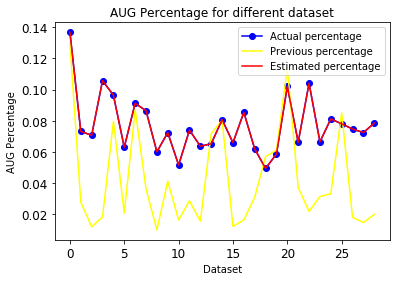

In [90]:
plt.plot(actual_percentage, color = 'blue', marker = 'o', label = 'Actual percentage')
plt.plot(previous_percentage, color = 'yellow', label = 'Previous percentage')
plt.plot(estimated_percentage, color = 'red', label = 'Estimated percentage')
plt.legend()
plt.title('AUG Percentage for different dataset')
plt.xlabel('Dataset')
plt.ylabel('AUG Percentage')
plt.show()

In [91]:
actual_percentage = percent(RNA_data, observed_data, start_alpha_list_beta_fixed, beta_list_beta_fixed, E, start_trans_beta_fixed, stop_codon_list, False, state_list_true, 'CUG')
previous_percentage = percent(RNA_data, observed_data, start_alpha_list_beta_fixed, beta_list_beta_fixed, E, start_trans_beta_fixed, stop_codon_list, True, state_list_true, 'CUG')
estimated_percentage = percent(RNA_data, observed_data, final_alpha_list_beta_fixed, beta_list_beta_fixed, E, final_trans_beta_fixed, stop_codon_list, True, state_list_true, 'CUG')

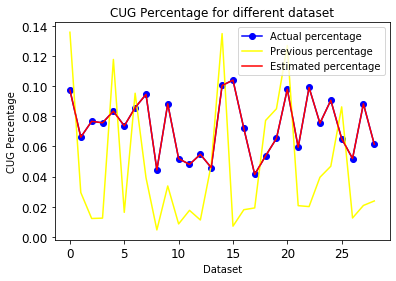

In [92]:
plt.plot(actual_percentage, color = 'blue', marker = 'o', label = 'Actual percentage')
plt.plot(previous_percentage, color = 'yellow', label = 'Previous percentage')
plt.plot(estimated_percentage, color = 'red', label = 'Estimated percentage')
plt.legend()
plt.title('CUG Percentage for different dataset')
plt.xlabel('Dataset')
plt.ylabel('CUG Percentage')
plt.show()

In [93]:
actual_percentage = percent(RNA_data, observed_data, start_alpha_list_beta_fixed, beta_list_beta_fixed, E, start_trans_beta_fixed, stop_codon_list, False, state_list_true, 'GUG')
previous_percentage = percent(RNA_data, observed_data, start_alpha_list_beta_fixed, beta_list_beta_fixed, E, start_trans_beta_fixed, stop_codon_list, True, state_list_true, 'GUG')
estimated_percentage = percent(RNA_data, observed_data, final_alpha_list_beta_fixed, beta_list_beta_fixed, E, final_trans_beta_fixed, stop_codon_list, True, state_list_true, 'GUG')

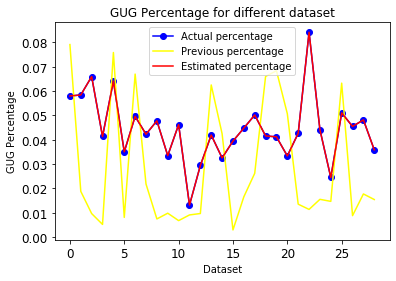

In [94]:
plt.plot(actual_percentage, color = 'blue', marker = 'o', label = 'Actual percentage')
plt.plot(previous_percentage, color = 'yellow', label = 'Previous percentage')
plt.plot(estimated_percentage, color = 'red', label = 'Estimated percentage')
plt.legend()
plt.title('GUG Percentage for different dataset')
plt.xlabel('Dataset')
plt.ylabel('GUG Percentage')
plt.show()